<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

__This starter notebook uses the [BERT](https://arxiv.org/abs/1810.04805) pretrained model from KerasNLP.__

**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


![BERT Architecture](http://miro.medium.com/v2/resize:fit:1032/0*x3vhaoJdGndvZqmL.png)


This notebook contains complete code to fine-tune BERT to perform a **Natural Language Inferencing (NLI)** model. NLI is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

Our **NLI model** will assign labels of 0, 1, or 2 (corresponding to **entailment, neutral, and contradiction**) to pairs of premises and hypotheses.

Note that the train and test set include text in **fifteen different languages**!


In this notebook, you will:

- Load the Contradictory, My Dear Watson dataset
- Explore the dataset
- Preprocess the data
- Load a BERT model from Keras NLP
- Train your own model, fine-tuning BERT as part of that
- Generate the submission file


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.16.1
KerasNLP version: 0.11.1


# Accelerator

Detect hardware, return appropriate distribution strategy

In [3]:
 try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    # instantiate a distribution strategy
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not activated")
    strategy = tf.distribute.MirroredStrategy() # Works on CPU, single GPU and multiple GPUs in a single VM.
    
print("replicas:", strategy.num_replicas_in_sync)

TPU not activated
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
replicas: 1


# Load the Contradictory, My Dear Watson dataset
Let's have a look at all the data files

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

In [6]:
DATA_DIR = './data/'

RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/train.csv
./data/sample_submission.csv


In [7]:
df_train = pd.read_csv(DATA_DIR + "train.csv")
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [8]:
df_test = pd.read_csv(DATA_DIR + "test.csv")
df_test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


Let's look at some pairs of sentences.

In [9]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

df_train.head(10).apply(lambda x : display_pair_of_sentence(x), axis=1)

df_train.shape

Premise : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ

(12120, 6)

# Explore the dataset

Let's look at the distribution of labels in the training set.

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_375/512453409.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])


Text(0.5, 1.0, 'Distribution of labels in the training set')

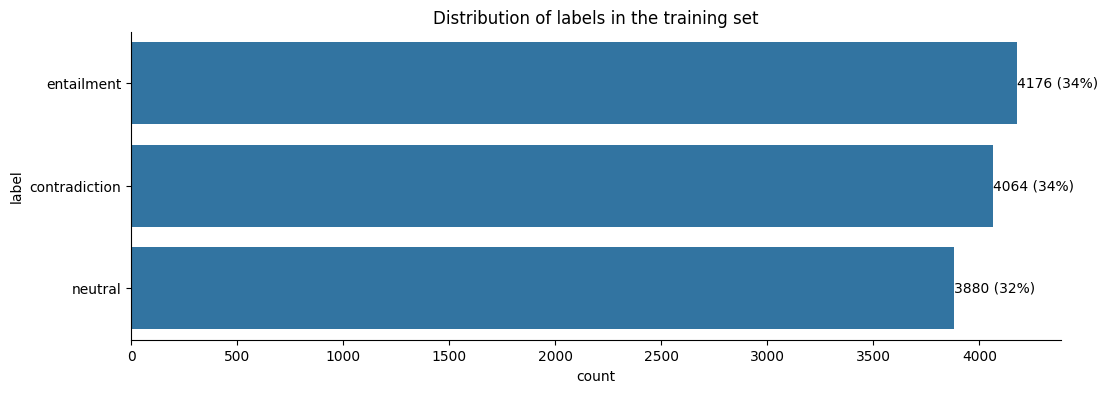

In [10]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_train, 
                   y="label",
                   order = df_train['label'].value_counts().index)

abs_values = df_train['label'].value_counts(ascending=False)
rel_values = df_train['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Let's look at the distribution of languages in the training set.

Text(0.5, 1.0, 'Distribution of languages in the training set')

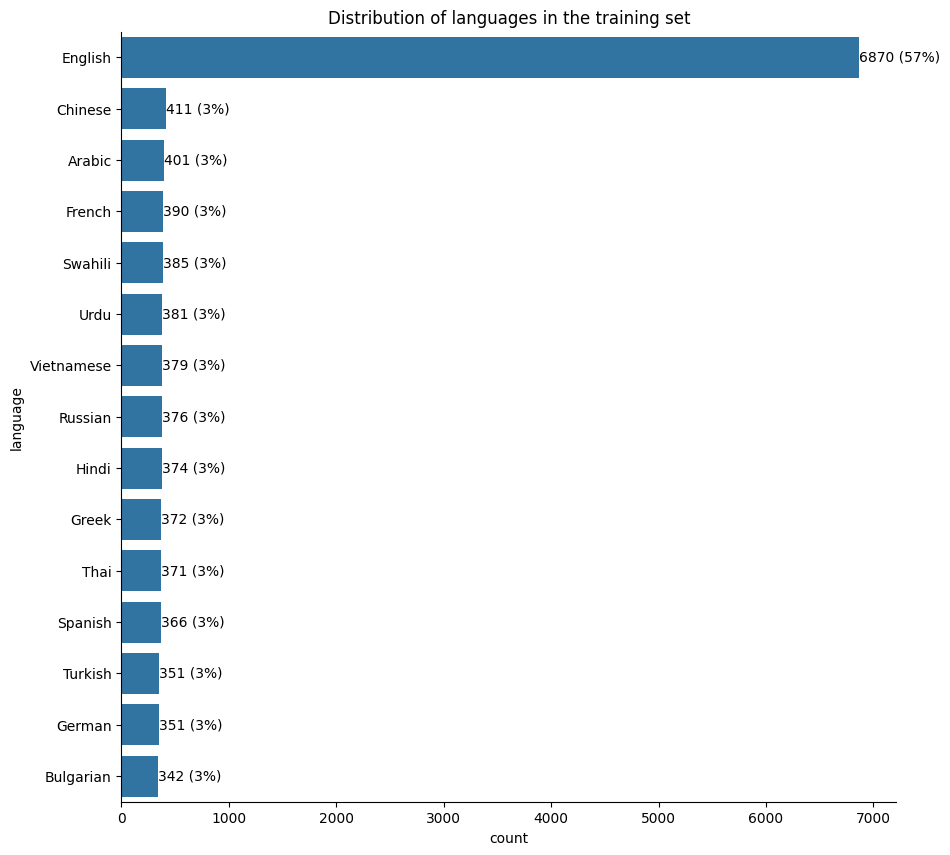

In [11]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=df_train, 
                   y="language",
                   order = df_train['language'].value_counts().index)

abs_values = df_train['language'].value_counts(ascending=False)
rel_values = df_train['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

Let's look at the length of the sentences

In [12]:
df_train["premise_length"] = df_train["premise"].apply(lambda x : len(x))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x : len(x))
df_train[["hypothesis_length", "premise_length"]].describe()

,hypothesis_length,premise_length
count,12120.000000,12120.000000
mean,53.892327,107.373185
std,25.302358,71.089954
min,4.000000,4.000000
25%,36.000000,55.000000
50%,51.000000,96.000000
75%,67.000000,146.000000
max,276.000000,967.000000


# Preprocess the data

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can  be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

Bert is only trained in English corpus. That's why people use multilingual Bert or XLM-Roberta for this competition.

Here are some models for multi-language NLP available in Keras NLP:
- bert_base_multi
- deberta_v3_base_multi
- distil_bert_base_multi
- xlm_roberta_base_multi
- xlm_roberta_large_multi


In [13]:
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(df_train.shape[0]*(1-VALIDATION_SPLIT))
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


Here's a utility function that splits the example into an `(x, y)` tuple that is suitable for `model.fit()`.

By default, `keras_nlp.models.BertClassifier` will tokenize and pack together raw strings using a `"[SEP]"` token during training.

Therefore, this label splitting is all the data preparation that we need to perform.

In [14]:
def split_labels(x, y):
    return (x[0], x[1]), y


training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_train[['premise','hypothesis']].values,
            keras.utils.to_categorical(df_train['label'], num_classes=3)
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

# Apply the preprocessor to every sample of train, val and test data using `map()`.
# [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data/AUTOTUNE) and `prefetch()` are options to tune performance, see
# https://www.tensorflow.org/guide/data_performance for details.

train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

# Load a BERT model from Keras NLP - Train the model

In [19]:
# Load a BERT model.

with strategy.scope():
    classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", num_classes=3, vocabulary_file='path_to_your_vocab_file')

    # in distributed training, the recommendation is to scale batch size and learning rate with the numer of workers.
    classifier.compile(optimizer=keras.optimizers.Adam(1e-5*strategy.num_replicas_in_sync),
                       loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    classifier.summary()

TypeError: <class 'keras_nlp.src.models.bert.bert_tokenizer.BertTokenizer'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras_nlp.src.models.bert.bert_tokenizer', 'class_name': 'BertTokenizer', 'config': {'name': 'bert_tokenizer', 'trainable': True, 'dtype': 'int32', 'vocabulary': None, 'sequence_length': None, 'lowercase': False, 'strip_accents': False, 'split': True, 'suffix_indicator': '##', 'oov_token': '[UNK]'}, 'registered_name': 'keras_nlp>BertTokenizer', 'assets': ['assets/tokenizer/vocabulary.txt'], 'weights': None}.

Exception encountered: Error when deserializing class 'BertTokenizer' using config={'name': 'bert_tokenizer', 'trainable': True, 'dtype': 'int32', 'vocabulary': None, 'sequence_length': None, 'lowercase': False, 'strip_accents': False, 'split': True, 'suffix_indicator': '##', 'oov_token': '[UNK]'}.

Exception encountered: BertTokenizer requires the `tensorflow-text` package. Please install with `pip install tensorflow-text`.

# Train your own model - Fine-tuning BERT

In [16]:
EPOCHS=3
history = classifier.fit(train_preprocessed,
                         epochs=EPOCHS,
                         validation_data=val_preprocessed
                        )

NameError: name 'classifier' is not defined

# Generate the submission file

Let's get the test data

In [ ]:
predictions = classifier.predict((df_test['premise'],df_test['hypothesis']), batch_size=BATCH_SIZE)

Now, we create a csv file with exactly 5195 entries plus a header row.

The file has 2 columns:
- id (sorted in any order)
- prediction (contains your predictions: 0 for entailment, 1 for neutral, 2 for contradiction)

In [ ]:
submission = df_test.id.copy().to_frame()
submission["prediction"] = np.argmax(predictions, axis=1)

submission

In [ ]:
submission.to_csv("submission.csv", index=False)

If you need details on how to submit from a notebook, review the FAQ on ["How do I make a submission?"]
(https://www.kaggle.com/c/contradictory-my-dear-watson/overview/frequently-asked-questions)

Good luck!
